# Temperature Profile Classification
Mirroring the work done by Dan Jone for GMM classification of Southern Ocean Argo float temperature profile data. 

(https://github.com/DanJonesOcean/GMM_example)

### Control Variables
Modifiable variables that control key aspects of the notebook, and can be modified to improve overall robustness or calculation time.

In [1]:
pcaNcontrol = 6
bicLoopControl = 2 #number of times bic value is calculated for each number of classes

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing

### Importing and storing data set
Different .csv files can be placed here to have the notebook work of different data sets. For local computation reduced data files are recommended.

In [3]:
df = pd.read_csv('Argo_T_profiles_very_small_subset.csv') #importing file, point to relevant data set

pressures = df.columns[2:].to_numpy() #converts pressures from pd to np, removing location data (columns 0 and 1 of .csv)
p = np.asarray([float(i) for i in pressures])
lon = df.iloc[:,0].to_numpy() #stores longitude information for ARGO float 
lat = df.iloc[:,1].to_numpy() #stores lattitude information for ARGO float
dataRaw = df.iloc[:,2:].to_numpy() #data to be used for GMM 

### Data standardisation
The data for the GMM process must first be standardised to account for the different pressure levels.

In [4]:
dataScaled = preprocessing.scale(dataRaw)

### Principle Component Analysis
This process is performed to reduce the number of dimensions of the the data, as well as to improve overall model
performance.

In [5]:
pca = PCA(n_components=pcaNcontrol) #initialising PCA object instance
pca.fit(dataScaled) #fitting model to data
dataPCA = pca.transform(dataScaled) #converting input data into PCA representation

### BIC score calculation
To identify the best fitting models a BIC score metric is used, with a lower BIC score indicating a better model. BIC scores for each number of classes will differ based on starting values used in the modelling, so repeated runs of the BIC scoring helps to provide a more overall score for each number of classes. The number of iterations for each quantity of classes can be controlled by modifying the bicLoopControl variable at the top of the notepad in [Control Variables](#Control-Variables).

In [6]:
bicMin = np.infty #setting current lowest bic score to infinity
bicRaw = []
nComponentsRange = range(2,40) 
cvTypes = ['full']

for i in range(bicLoopControl):
    bicRaw.append([])
    bicCurrent=bicRaw[i]
    for cvType in cvTypes:
        for nComponent in nComponentsRange:
            gmmodel = mixture.GaussianMixture(n_components=nComponent, covariance_type=cvType)
            gmmodel.fit(dataPCA) 
            bicCurrent.append(gmmodel.bic(dataPCA))
            if bicCurrent[-1] < bicMin:
                bicMin = bicCurrent[-1]
                bestGMModel = gmmodel   

### BIC minimising
If multiple BIC runs have been calculated then the minimum of the BIC scores for seperate runs of the same number of components should be calculated.

In [7]:
bicAvg = []
bicLen = len(bicRaw) #this should be equal to bicLoopControl, to avoid out of bounds index this length is recalculated

for i in range(len(bicRaw[0])): #loops through different quantities
    bicSingleMin = np.inf
    for j in range(bicLen): #loops through different iterations of BIC scores for the same quantity
        if bicSingleMin > bicRaw[j][i]:
            bicSingleMin = bicRaw[j][i]
    bicSingleMin = np.round(bicSingleMin,2)
    bicAvg.append(bicSingleMin)

### BIC score plotting
The minimum BIC score indicates the ideal number of classes to be used in the model. 

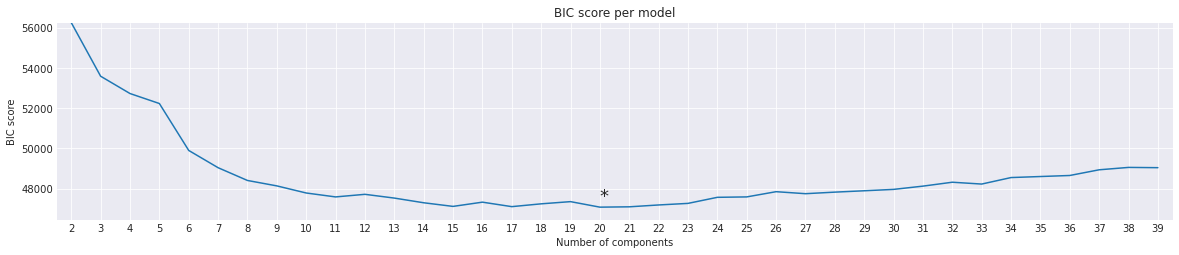

Number of classes with minimum BIC score over 2 iteration(s): 20


In [8]:
bicArr = np.array(bicAvg)

plt.figure(1, figsize=(20, 8))
plt.style.use("seaborn-darkgrid")
spl = plt.subplot(2, 1, 1)
plt.plot(nComponentsRange,bicArr)
xpos = np.where(bicArr == np.amin(bicArr))[0][0] + nComponentsRange[0]
plt.text(xpos, bicArr.min()*0.97 + 0.03*bicArr.max(), '*', fontsize=18)
plt.xticks(nComponentsRange)
plt.xlim([nComponentsRange[0]-0.5, nComponentsRange[-1]+0.5])
plt.ylim([bicArr.min()*1.01 - 0.02*bicArr.max(), bicArr.max()])
plt.title("BIC score per model")
spl.set_xlabel("Number of components")
spl.set_ylabel("BIC score")
plt.show()

nComp = bestGMModel.n_components
print("Number of classes with minimum BIC score over "+str(bicLoopControl)+" iteration(s): "+str(nComp))

### Assigning class labels to each profile based on the best GMM
Implementation of classification.

In [9]:
labels = bestGMModel.predict(dataPCA) #assignment of class labels from best GMM

posteriorProbs = bestGMModel.predict_proba(dataPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)

df.insert(2, "label", labels, True)
df.insert(3, "max posterior prob", maxPosteriorProbs, True)

### Calculating properties of profiles based on class assignment

In [10]:
groupedUnsorted = df.groupby("label") #group profiles according to label
dfMeans = groupedUnsorted.mean() #calculate mean of all profiles in each class

### Sort the labels based on mean near-surface temperatures

In [11]:
T15Means = dfMeans['15.0'].to_numpy() #extract sea surface temperatures (SSTs)
old2new = np.argsort(T15Means) #sort mean temp at 15 dbar from coldest to warmest
di = dict(zip(old2new, range(0, nComp))) #create dictionary object for sorting
df.insert(3, "labelSorted", df["label"].map(di))

In [24]:
T15Means

array([16.0087667 , 10.29927638, -0.83556592, 17.49241578,  2.7144692 ,
       19.10791492, 17.06492946, 12.31702782,  6.94459061, 12.89075811,
        4.96044782, 11.04154571,  0.70101682, 19.84359182, 16.4034623 ,
       10.95124209, 15.36808261,  6.63146048, 19.33485187, 17.31285795])

### Use pandas to calculate the properties of the profiles by sorted label

In [12]:
grouped = df.groupby("labelSorted") #group profiles according to label
dfgMeans = grouped.mean() #calculates mean of all profiles in each class
dfgStds = grouped.std() #calculates stdevs of all profiles in each class
nprofs = grouped['x'].count().to_numpy() #identifies number of profiles in each class

### Confirmation of sorting
The means printed below should be ordered, going from coldest to warmest.

In [13]:
print(dfgMeans['15.0'])

labelSorted
0     -0.835566
1      0.701017
2      2.714469
3      4.960448
4      6.631460
5      6.944591
6     10.299276
7     10.951242
8     11.041546
9     12.317028
10    12.890758
11    15.368083
12    16.008767
13    16.403462
14    17.064929
15    17.312858
16    17.492416
17    19.107915
18    19.334852
19    19.843592
Name: 15.0, dtype: float64


### Plotting the means and standard deviations of the classes by profile

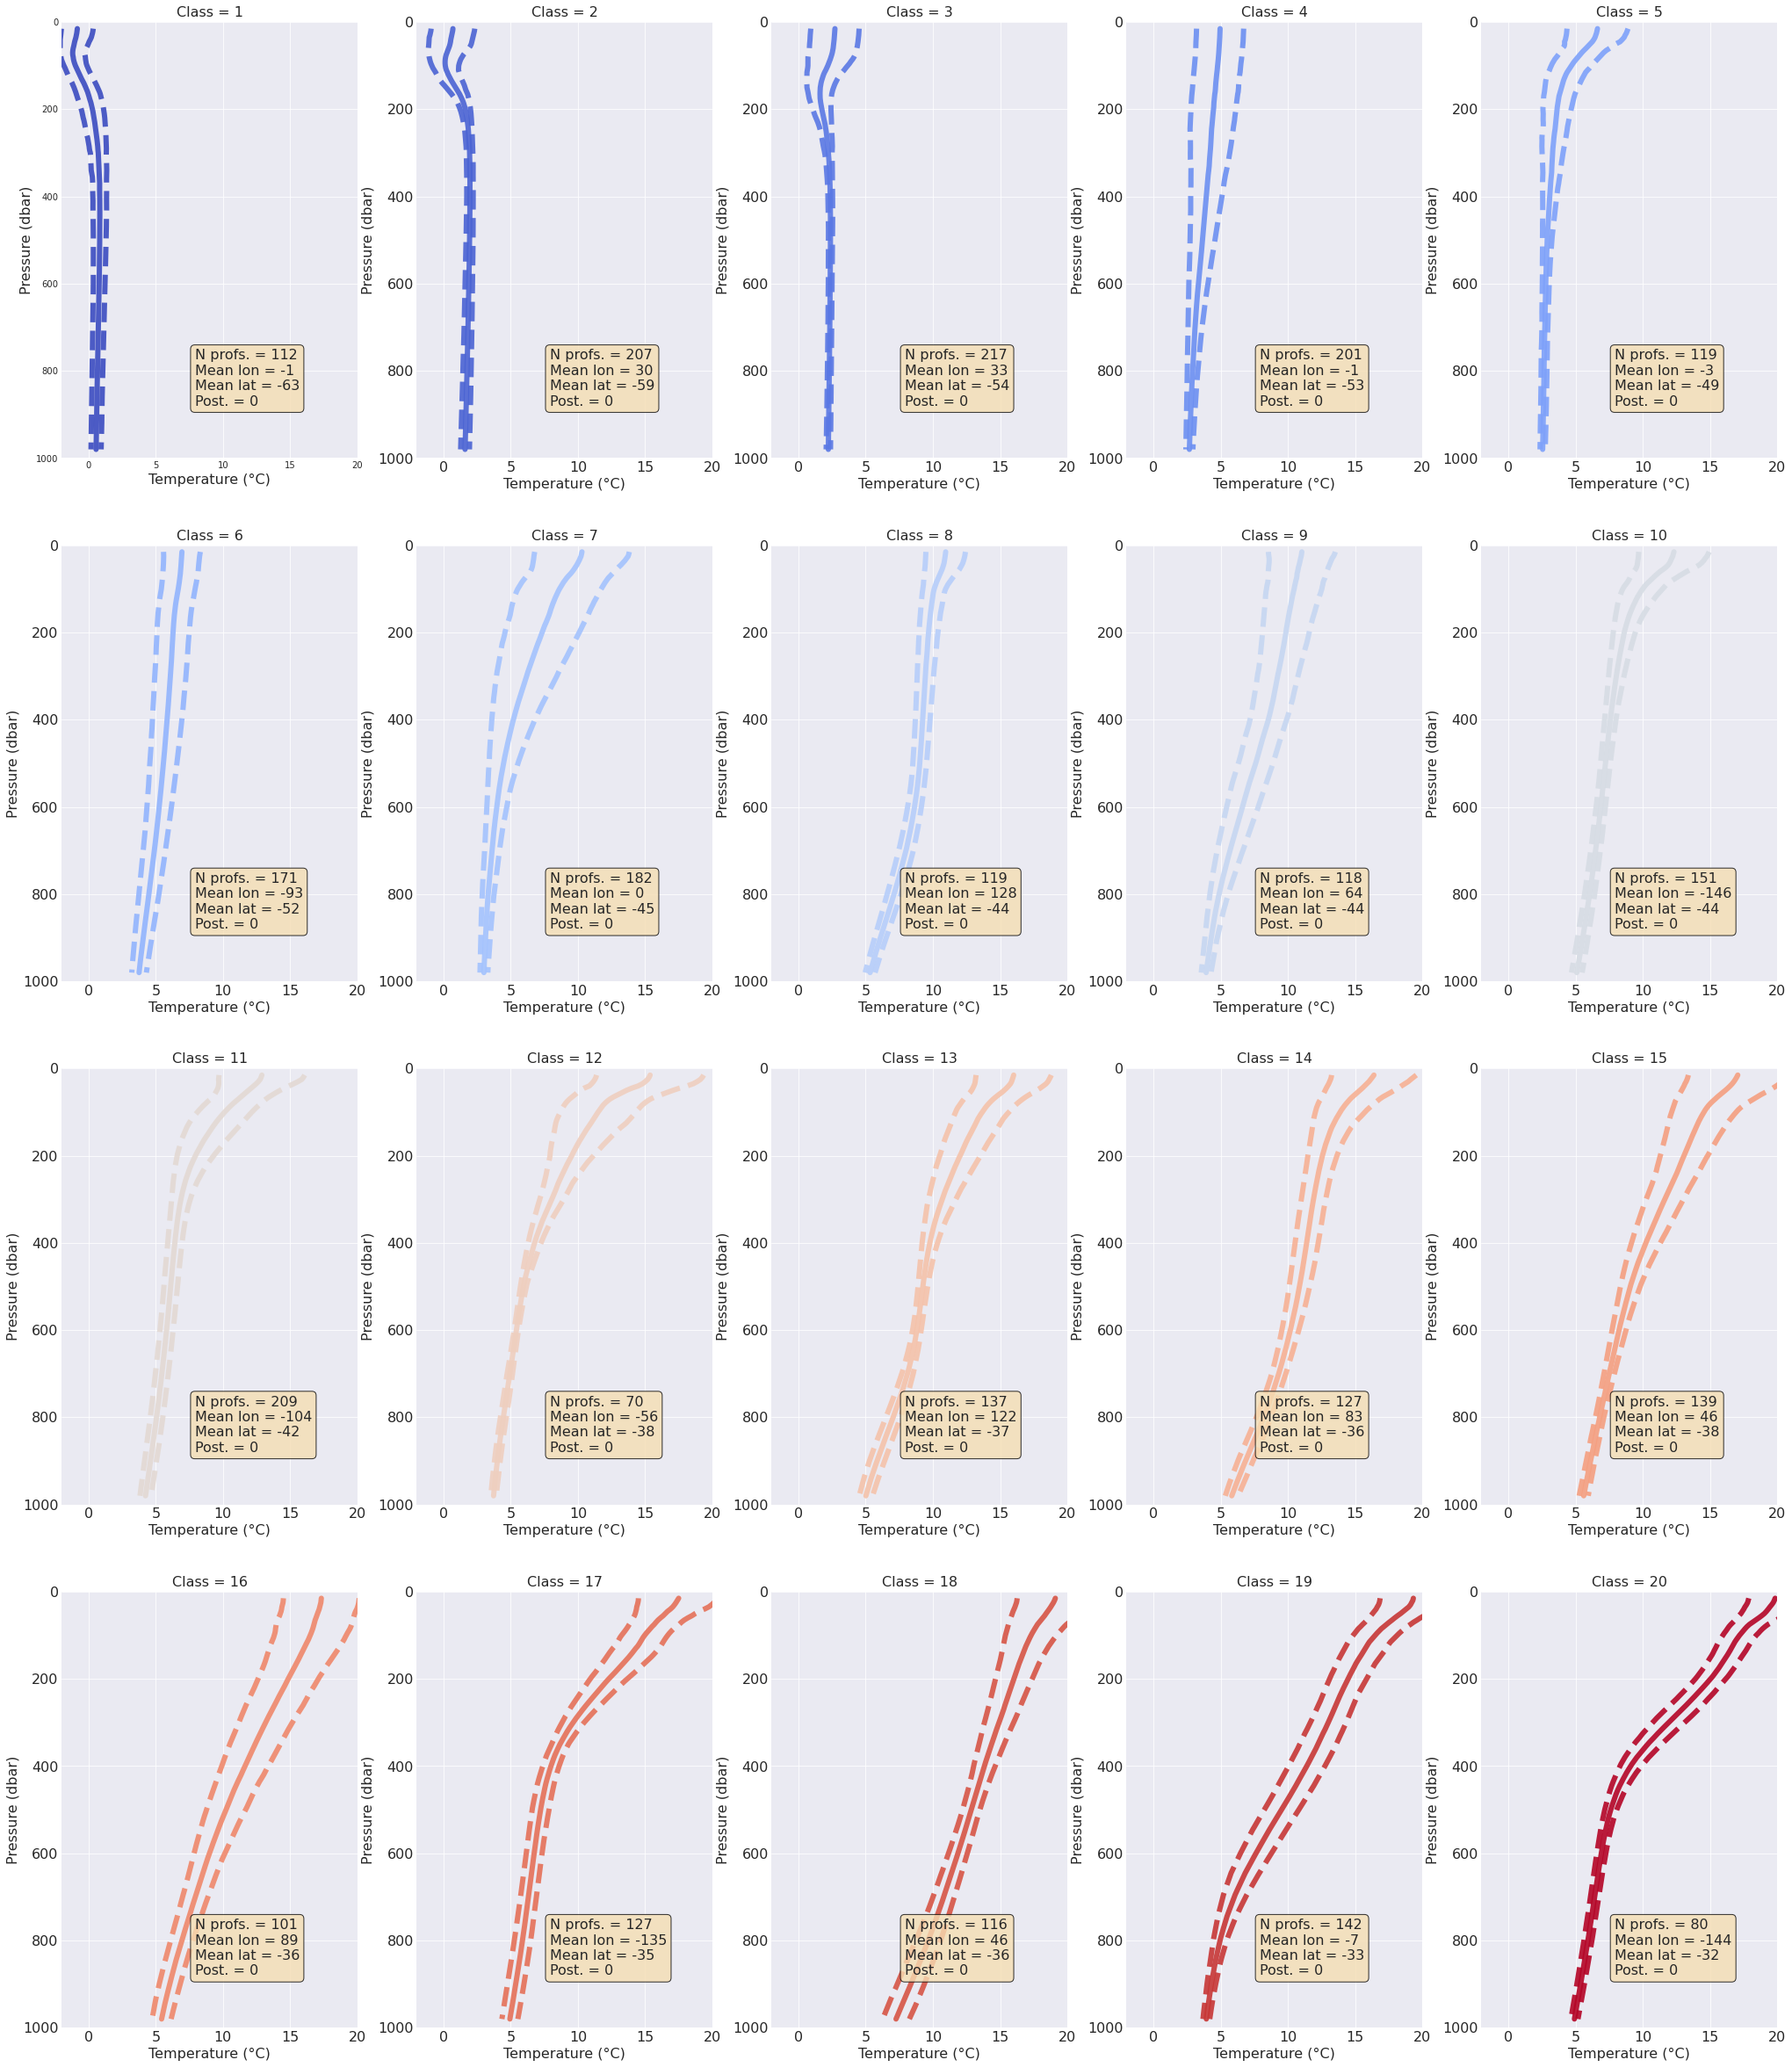

In [14]:
plt.figure(2, figsize=(35,42))
plt.style.use("seaborn-darkgrid")
palette = cm.coolwarm(np.linspace(0,1, nComp)) #colour palette for plotting

num = 0
for nrow in range(0, nComp):
    num += 1
    
    meanLon = dfgMeans.iloc[nrow, 0]
    meanLat = dfgMeans.iloc[nrow, 1]
    meanMaxPP = dfgMeans.iloc[nrow, 3]
    meanT = dfgMeans.iloc[nrow,4:].to_numpy()
    
    stdLon = dfgStds.iloc[nrow, 0]
    stdLat = dfgStds.iloc[nrow, 1]
    stdMaxPP = dfgStds.iloc[nrow, 3]
    stdT = dfgStds.iloc[nrow, 4:].to_numpy()
    
    plt.subplot(int(np.ceil(nComp/5)), 5, num)
    plt.plot(meanT, p, marker='', linestyle="solid", color=palette[nrow], linewidth=6.0, alpha=0.9)
    plt.plot(meanT+stdT, p, marker='', linestyle="dashed", color=palette[nrow], linewidth=6.0, alpha=0.9)
    plt.plot(meanT-stdT, p, marker='', linestyle="dashed", color=palette[nrow], linewidth=6.0, alpha=0.9)
    
    plt.xlim([-2,20])
    plt.ylim([0,1000])
    ax = plt.gca()
    ax.invert_yaxis()
    ax.grid(True)
    
    fs = 16 #font size
    plt.xlabel("Temperature (°C)", fontsize=fs)
    plt.ylabel("Pressure (dbar)", fontsize=fs)
    plt.title("Class = "+str(num), fontsize=fs)
    mpl.rc("xtick", labelsize=fs)
    mpl.rc("ytick", labelsize=fs)
    
    
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs[nrow], ),
        r'Mean lon = %i' % (meanLon, ),
        r'Mean lat = %i' % (meanLat, ),
        r'Post. = %i' % (meanMaxPP, )))
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs, verticalalignment='top', bbox=props)
    
plt.show()

### Plotting location and cluster

In [15]:
def invert(inArray):
    outArray = []
    for i in range(len(inArray)):
        for j in range(len(inArray)):
            if inArray[j] == i:
                outArray.append(j)
    return outArray

floatLon = df["x"]
floatLat = df["y"]
floatCol = df["label"]
floatColLookup = invert(dfgMeans["label"])
floatColSwitched = []

for i in floatCol:
    floatColSwitched.append(floatColLookup[i])

Text(0.5, 1.0, 'GMM groups, sorted by mean temperature')

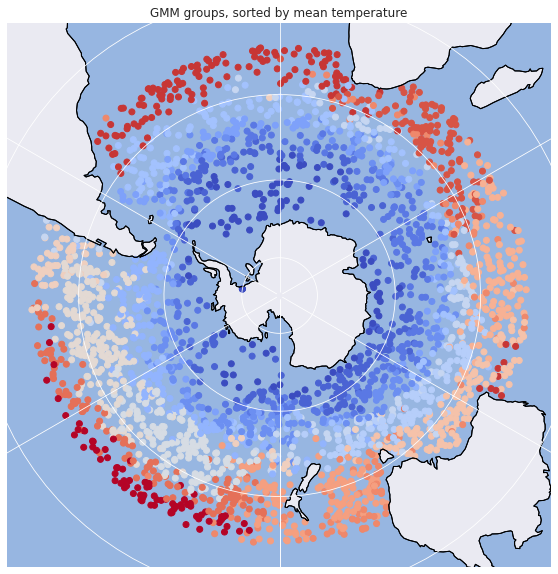

In [16]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.coastlines()
ax.gridlines()
plt.scatter(floatLon, floatLat, color=palette[floatColSwitched], transform=ccrs.PlateCarree(),cmap='RdBu_r')
plt.title("GMM groups, sorted by mean temperature")